In [138]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import os

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

# To read an image from url
from imageio import imread

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_25384\1696291578.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [139]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [140]:
os.environ['TORCH_HOME'] = './'

In [141]:
# Import vgg Model
trainedModel = torchvision.models.vgg19(pretrained=True)

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\hub.py:739: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [142]:
# Freeze all layers
# for p in trainedModel.named_parameters():
    # p[1].requires_grad = False
    
# Freeze all layers
for p in trainedModel.parameters():
   p.requires_grad = False

In [143]:
# Set to evaluation mode
trainedModel.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [144]:
# use GPU
trainedModel.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [145]:
# Import content image
contentImage = imread("./images/content-image.jpg")

# Import style image
styleImage = imread("./images/style-image1.jpg")
# styleImage = imread("./image/style-image2.jpg")

# Target image
targetImage = np.random.randint(low=0, high=255, size=contentImage.shape, dtype=np.uint8)

print(contentImage.shape)
print(styleImage.shape)
print(targetImage.shape)

C:\Users\elmog\AppData\Local\Temp\ipykernel_25384\3235472342.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  contentImage = imread("./images/content-image.jpg")
C:\Users\elmog\AppData\Local\Temp\ipykernel_25384\3235472342.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  styleImage = imread("./images/style-image1.jpg")


(2084, 4624, 3)
(2084, 4624, 3)
(2084, 4624, 3)


In [146]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.Normalize( #use recommended vgg mean & std dev for normalization
        mean=[0.485,0.456,0.406],
        std =[0.229,0.224,0.225]
        )
    #T.RandomHorizontalFlip(p=0.5)
])

In [147]:
# apply transformations + unsqueeze => to add 0 to act as a 4th dimension "4D tensor"
#Model Input Expectation: Most models like VGG (used in style transfer) expect a batch of images as input. This means the input should have the shape [B, C, H, W], where:
#B (Batch size): The number of images being processed simultaneously. A batch size of 1 means you are processing just one image.
#C (Channels), H (Height), and W (Width) 
# This changes the shape of the image tensor from [C, H, W] to [1, C, H, W], making it a 4D tensor. 
# This is necessary because the model expects the input to have the shape of a batch of images, even if it's just a single image.

contentImage= transform( contentImage ).unsqueeze(0).to(device)
styleImage  = transform(  styleImage  ).unsqueeze(0).to(device)
targetImage = transform( targetImage  ).unsqueeze(0).to(device)

print(contentImage.shape)
print(styleImage.shape)
print(targetImage.shape)

torch.Size([1, 3, 256, 568])
torch.Size([1, 3, 256, 568])
torch.Size([1, 3, 256, 568])


c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [148]:
# check images BEFORE style transfer

xViewLength = 8
fig,ax = plt.subplots(3,1, figsize=(xViewLength,xViewLength*568/256))

# matplot lib uses (Width, Height, channels)
img = contentImage.cpu().squeeze().numpy().transpose((1,2,0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[0].imshow(img)
ax[0].set_title('Content Image')

img = styleImage.cpu().squeeze().numpy().transpose((1,2,0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[1].imshow(img)
ax[1].set_title('Style Image')

img = targetImage.cpu().squeeze().numpy().transpose((1,2,0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[2].imshow(img)
ax[2].set_title('Target Image')

Text(0.5, 1.0, 'Target Image')

In [149]:
# model features from CNN

def modelLayersFeatureMaps(img, trainedModel):
    
    # Initialize feature maps as a list
    featureMaps     = []
    featureNames    = []
    
    convLayerIdx    = 0
    
    # print(f'length of trainedModel features = {len(trainedModel.features)}')
    
    # loop through all layers in "features" block
    for layer in range(len(trainedModel.features)):

        # print out info from this layer
        # print(layer, trainedModel.features[layer])
        
        # process the image through this layer
        img = trainedModel.features[layer](img)
        
        # store the img if it's a conv2d layer
        if 'Conv2d' in str(trainedModel.features[layer]):
            featureMaps.append( img)
            featureNames.append('ConvLayer_' + str(convLayerIdx))
            convLayerIdx += 1
        
    return featureMaps, featureNames

In [150]:
def gram_matrix(matrix):
    
    # step1: get matrix channels, height, width
    _,channels,height,width = matrix.shape
    
    # step2: reshape matrix to 2D
    matrix = matrix.reshape(channels, width * height)
    
    # Compute & return covariance matrix divided by total number of pixels in that map or image
    gram = torch.mm(matrix,matrix.t()) / (channels * width * height)
    
    return gram

In [151]:
#get the feature maps & feature names list
featureMaps,featureNames = modelLayersFeatureMaps(contentImage, trainedModel)

print(f'length of featureNames = {len(featureNames)}')

for i in range(len(featureNames)):
    print('feature map "%s": size of its featureName = %s'%(featureNames[i],(featureMaps[i].shape)))

length of featureNames = 16
feature map "ConvLayer_0": size of its featureName = torch.Size([1, 64, 256, 568])
feature map "ConvLayer_1": size of its featureName = torch.Size([1, 64, 256, 568])
feature map "ConvLayer_2": size of its featureName = torch.Size([1, 128, 128, 284])
feature map "ConvLayer_3": size of its featureName = torch.Size([1, 128, 128, 284])
feature map "ConvLayer_4": size of its featureName = torch.Size([1, 256, 64, 142])
feature map "ConvLayer_5": size of its featureName = torch.Size([1, 256, 64, 142])
feature map "ConvLayer_6": size of its featureName = torch.Size([1, 256, 64, 142])
feature map "ConvLayer_7": size of its featureName = torch.Size([1, 256, 64, 142])
feature map "ConvLayer_8": size of its featureName = torch.Size([1, 512, 32, 71])
feature map "ConvLayer_9": size of its featureName = torch.Size([1, 512, 32, 71])
feature map "ConvLayer_10": size of its featureName = torch.Size([1, 512, 32, 71])
feature map "ConvLayer_11": size of its featureName = torch

In [152]:
# Showing the image inside the different layers

contentFeatureMaps,contentFeatureNames = modelLayersFeatureMaps(contentImage, trainedModel)

xViewLength=10
rows=6
cols=2
fix,axs = plt.subplots(rows,cols,figsize=(xViewLength,xViewLength*568/256))

#show first 10 feature maps layers
for i in range(6):
    
    print(contentFeatureMaps[i].cpu().squeeze().numpy())
    
    #avg over all feature maps from this layer & normalize
    img = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy(), axis=0) 
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Calculate row and column index for axs
    # row, col = divmod(i, 1)

    axs[i, 0].imshow(img, cmap='viridis')
    axs[i, 0].set_title('Content Layer' + str(contentFeatureNames[i]))

    #now show the gram matrix
    img = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    axs[i, 1].imshow(img, cmap='viridis', vmax=0.1)
    axs[i, 1].set_title('Gram Matrix' + str(contentFeatureNames[i]))
    
plt.tight_layout()
plt.show()



[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.07790470e-01
   3.76075387e-01 4.45384979e-01]
  [0.00000000e+00 2.88208604e-01 5.57647824e-01 ... 4.29503441e-01
   5.78528881e-01 5.31899095e-01]
  [4.41167355e-01 9.11238313e-01 5.11054158e-01 ... 6.73796296e-01
   7.65630245e-01 5.76709390e-01]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.14006865e-01 0.00000000e+00 0.00000000e+00 ... 2.73915505e+00
   0.00000000e+00 1.62145758e+00]
  [2.05113792e+00 3.65656567e+00 2.15213537e+00 ... 2.37044358e+00
   1.07761919e+00 2.07396603e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.72960401e+00]
  ...
  [3.64310789e+00 3.46044898e-01 0.00000000e+00 ... 2.37912834e-01
   3.15035

In [153]:
# Showing the image inside the different layers

styleFeatureMaps,styleFeatureNames = modelLayersFeatureMaps(styleImage, trainedModel)

xViewLength=10
rows=6
cols=2
fix,axs = plt.subplots(rows,cols,figsize=(xViewLength,xViewLength*568/256))

#show first 10 feature maps layers
for i in range(6):
    
    print(styleFeatureMaps[i].cpu().squeeze().numpy())
    
    #avg over all feature maps from this layer & normalize
    img = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy(), axis=0) 
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # Calculate row and column index for axs
    # row, col = divmod(i, 1)

    axs[i, 0].imshow(img, cmap='viridis')
    axs[i, 0].set_title('Content Layer' + str(styleFeatureNames[i]))

    #now show the gram matrix
    img = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    axs[i, 1].imshow(img, cmap='viridis', vmax=0.1)
    axs[i, 1].set_title('Gram Matrix' + str(styleFeatureNames[i]))
    
plt.tight_layout()
plt.show()



[[[0.09033895 0.502568   0.53316164 ... 0.         0.         0.        ]
  [0.         0.3134117  0.2919134  ... 0.         0.28588307 0.0297994 ]
  [0.01473135 0.34027827 0.21945071 ... 0.00573683 0.12244189 0.03653181]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.07089525 0.14671087 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         1.5545181  1.4962524  ... 1.3997095  0.88140506 3.4301996 ]
  [0.         0.32375082 0.16339928 ... 0.21331184 0.         3.3866072 ]
  [0.         0.6084608  0.32801396 ... 0.05314568 0.         2.7674863 ]
  ...
  [0.         0.33616367 0.         ... 0.         0.         3.2221026 ]
  [0.         4.261645   1.4600123  ... 0.51746935 0.         1.9997503 ]
  [0.         0.6049812  0.8097812  ... 1.8101711  0.         0.        ]]

 [[0.21885812 0.20137489 0.22028148 ... 0.         0.         0.        ]
  [0.54387236 0.350340

In [154]:
# Select the layers to use in style transfer

# contentLayers       = ['ConvLayer_0', 'ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4'] 
contentLayers       = ['ConvLayer_1', 'ConvLayer_4' ] 
styleLayers         = ['ConvLayer_1', 'ConvLayer_2' , 'ConvLayer_3' , 'ConvLayer_4' , 'ConvLayer_5' ]
weightStyleLayers   = [     1       ,       0.5     ,       0.5     ,       0.2     ,       0.1     ]

In [155]:
targetImage.to(device).requires_grad_(True)
styleScaling    = 1e6
epochs          = 1000
optimizer       = torch.optim.RMSprop([targetImage], lr=0.005)

for epochi in range(epochs):
    
    #extract the target feature maps
    targetFeatureMaps,targetFeatureNames = modelLayersFeatureMaps(targetImage,trainedModel)
    
    #initialize the loss
    styleLoss   = 0
    contentLoss = 0
    
    #loop over layers
    for layer in range(len(targetFeatureNames)):
        
        #compute the content loss
        if targetFeatureNames[layer] in contentLayers:
            contentLoss += torch.mean( (targetFeatureMaps[layer]-contentFeatureMaps[layer])**2 )
            
        #compute the style loss
        if targetFeatureNames[layer] in styleLayers:
            
            # compute gram matrix in order to compute the loss from gram matrix
            gramTarget  = gram_matrix(targetFeatureMaps[layer])
            gramStyle   = gram_matrix(styleFeatureMaps[layer])
            
            #compute their loss
            styleLoss  += torch.mean( (gramTarget-gramStyle)**2 ) * weightStyleLayers[styleLayers.index(targetFeatureNames[layer])]
            
    #combined loss
    combinedLoss = styleScaling*styleLoss + contentLoss
    
    #backprop
    optimizer.zero_grad()
    combinedLoss.backward()
    optimizer.step()
    

Text(0.5, 1.0, 'Target Image')

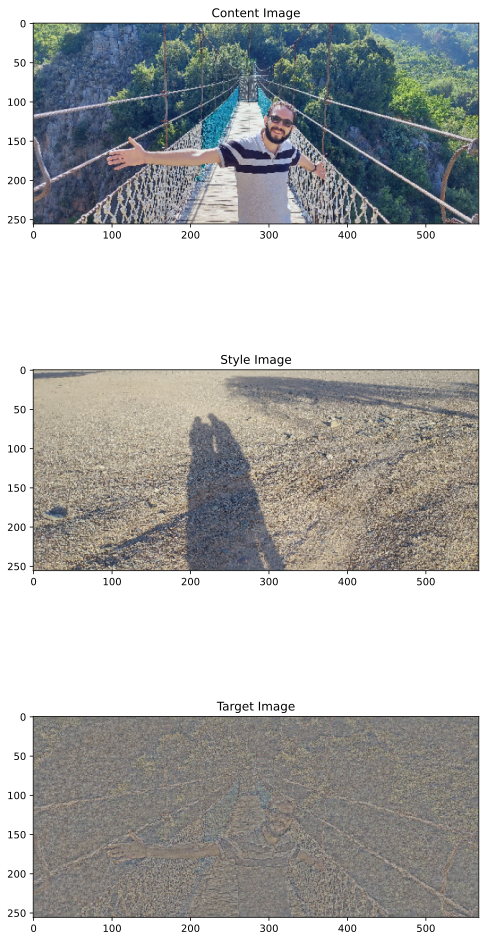

In [157]:
# check images after style transfer

xViewLength = 8
fig,ax = plt.subplots(3,1, figsize=(xViewLength,xViewLength*568/256))

# matplot lib uses (Width, Height, channels)
img = contentImage.cpu().squeeze().numpy().transpose((1,2,0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[0].imshow(img)
ax[0].set_title('Content Image')

img = styleImage.cpu().squeeze().numpy().transpose((1,2,0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[1].imshow(img)
ax[1].set_title('Style Image')

img = targetImage.detach().cpu().squeeze().numpy().transpose((1,2,0))
img = (img - np.min(img)) / (np.max(img) - np.min(img))
ax[2].imshow(img)
ax[2].set_title('Target Image')